In [3]:
# fetch data

import pickle
from sortify import *

import matplotlib.pyplot as plt
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(figsize=(15,10))
import seaborn as sns
import os
import glob

# files = glob.glob('cache/*')
# for f in files:
#     os.remove(f)

try:
    tracks = pd.read_pickle('cache/tracks.pkl')
except FileNotFoundError:
    print('Fetching user tracks...')
    tracks = get_user_tracks()
    tracks.to_pickle('cache/tracks.pkl')
    
try:
    features = pd.read_pickle('cache/features.pkl')
except FileNotFoundError:
    print('Fetching track features...')
    features = get_track_features(tracks.index)
    features.to_pickle('cache/features.pkl')
    
try:
    timbre = pd.read_pickle('cache/timbre.pkl')
except FileNotFoundError:
    print('Fetching track timbre data...')
    timbre = get_timbre_data(tracks.index)
    timbre.to_pickle('cache/timbre.pkl')

try:
    with open('cache/related_artists.pkl', 'rb') as f:
        related_artists = pickle.load(f)
except FileNotFoundError:
    print('Fetching related artists...')
    related_artists = get_related_artists(tracks.artist.unique())
    with open('cache/related_artists.pkl', 'wb') as f:
        pickle.dump(related_artists, f)
    
tracks = tracks[tracks.artist.isin(related_artists)]
features = features[features.index.isin(tracks.index)]
timbre = timbre[timbre.index.isin(tracks.index)]
    
try:
    artist_data = pd.read_pickle('cache/artist_data.pkl')
except FileNotFoundError:
    print('Fetching artist data...')
    all_artists = set()
    for artist, related_artist_list in related_artists.items():
        all_artists.add(artist)
        for related_artist in related_artist_list:
            all_artists.add(related_artist)
    artist_data = get_artist_data(list(all_artists))
    artist_data.to_pickle('cache/artist_data.pkl')

Fetching artist data...


In [4]:
# count genres

genres = np.unique(np.concatenate(artist_data.genres.values))

artist_genre_counts = pd.DataFrame(np.zeros((len(tracks), len(genres))), index=tracks.index, columns=genres)
related_genre_counts = pd.DataFrame(np.zeros((len(tracks), len(genres))), index=tracks.index, columns=genres)

for track in tqdm(tracks.itertuples(), total=len(tracks)):
    for genre in artist_data.loc[track.artist].genres:
        artist_genre_counts.loc[track[0], genre] += 1
    
    for related_artist in related_artists[track.artist]:
        for genre in artist_data.loc[related_artist].genres:
            related_genre_counts.loc[track[0], genre] += 1
            
genre_counts = artist_genre_counts + related_genre_counts * 0

c:\python37\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


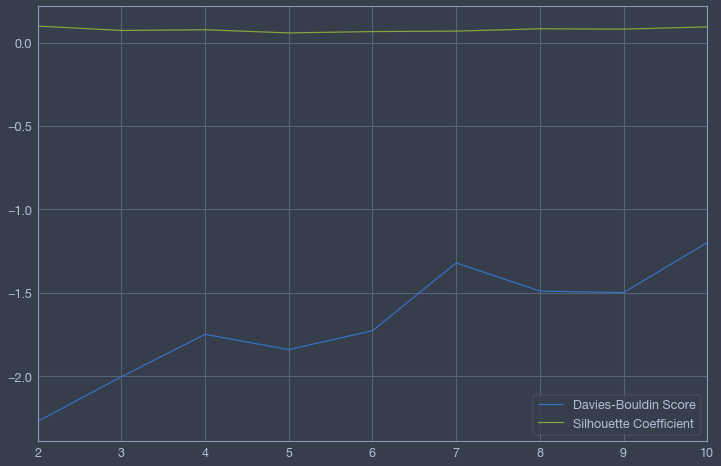

2 265
3 652
6 1013
7 178
4 382
1 268
8 903
5 367
0 103
9 1


In [54]:
# build model

from sklearn.metrics import completeness_score, calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.cluster import *
from sklearn.mixture import *
import hdbscan

feature_list = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
#     'liveness',
    'valence',
    'tempo',
    'time_signature'
]
categorical = ['key', 'mode', 'time_signature']

X = features[feature_list]
X = X.drop(categorical, axis=1).join(pd.DataFrame(OneHotEncoder(sparse=False).fit_transform(X[categorical]), index=X.index))

X_t = timbre.copy()
X_t.columns = [f'timbre_{i}' for i in range(X_t.shape[1])]
X = X.join(X_t)
# X = X_t

# scaler = PowerTransformer()
scaler = StandardScaler()
# scaler = QuantileTransformer(output_distribution='normal')
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# X = pd.DataFrame(FactorAnalysis(5).fit_transform(X), index=X.index)

genre_counts = artist_genre_counts + related_genre_counts * 0
X_g = genre_counts.copy()
X_g = X_g[X_g.columns[X_g.sum()>=1]]
X_g = pd.DataFrame(MinMaxScaler().fit_transform(X_g), columns=X_g.columns, index=X_g.index)
# X_g = pd.DataFrame(PCA(200).fit_transform(X_g), index=X_g.index)
# X_g = pd.DataFrame(LatentDirichletAllocation(5).fit_transform(X_g), index=X_g.index)
# X = X.join(X_g, rsuffix='_genre')

# X = X_g

# X = pd.DataFrame(FastICA(5).fit_transform(X), index=X.index)
# X = pd.DataFrame(KernelPCA(5, kernel='rbf').fit_transform(X), index=X.index)

model = KMeans(n_clusters=8)
# model = GaussianMixture(n_components=10)
# model = Birch(threshold=1)
# model = DBSCAN(0.8, 20)
# model = AgglomerativeClustering(n_clusters=8, linkage='ward')
# model = AgglomerativeClustering(n_clusters=8)
# model = SpectralClustering(n_clusters=8)
# model = hdbscan.HDBSCAN(min_cluster_size=20)
# model = OPTICS(min_samples=50)

test_n_clusters = True

if test_n_clusters:
    scores = {
        'Davies-Bouldin Score': [],
        'Silhouette Coefficient': [],
    }
    for i in trange(2,11):
        model.__init__(n_clusters=i)
#         model.__init__(n_components=i)
#         model.__init__(min_samples=2*i)
        clustering = model.fit_predict(X)
        scores['Davies-Bouldin Score'].append(1 - davies_bouldin_score(X, clustering))
        scores['Silhouette Coefficient'].append(silhouette_score(X, clustering))
    scores = pd.DataFrame(scores, index=np.arange(2,11))
    scores.plot()
    plt.show()
    
else:
    clustering = model.fit_predict(X)
    
    print(f'Davies-Bouldin Score: {1 - davies_bouldin_score(X, clustering)}')
    print(f'Silhouette Coefficient: {silhouette_score(X, clustering)}')
    print()

track_cluster = {}
cluster_tracks = {}
for i in range(len(X)):
    track_cluster[X.index[i]] = clustering[i]
    if clustering[i] not in cluster_tracks:
        cluster_tracks[clustering[i]] = [X.index[i]]
    else:
        cluster_tracks[clustering[i]].append(X.index[i])
for cluster in cluster_tracks:
    print(cluster, len(cluster_tracks[cluster]))

In [201]:
genre_counts = artist_genre_counts + related_genre_counts * 0

In [55]:
counts = {'cluster': [], 'genre': [], 'count': []}
for cluster in cluster_tracks:
    cluster_genres = dict()
    total_tracks = 0
    for track_id in cluster_tracks[cluster]:
        track_genres = genre_counts.loc[track_id]
        for genre, count in track_genres[track_genres!=0].items():
            if genre in cluster_genres:
                cluster_genres[genre] += count
            else:
                cluster_genres[genre] = count
        total_tracks += 1
    for genre, count in cluster_genres.items():
        counts['cluster'].append(cluster)
        counts['genre'].append(genre)
        counts['count'].append(count / total_tracks)

counts = pd.DataFrame(counts)
counts['genre'] = counts.genre.str.title()
counts['genre'] = counts.genre.replace('Edm', 'EDM')
counts.sort_values('count', ascending=False, inplace=True)
original_counts = counts.copy()

clusters_to_name = set(counts['cluster'].unique())
playlists = {}
cluster_names = {}
while clusters_to_name:
    cluster = counts.iloc[0]['cluster']
    name = counts.iloc[0]['genre']
    playlists[name] = cluster
    cluster_names[cluster] = name
    counts = counts[ (counts['cluster']!=cluster) & (counts['genre']!=name) ]
    clusters_to_name.remove(cluster)
    
playlist_tracks = dict()
cluster_counts = dict()
for name in playlists:
    cluster_counts[name] = dict()
    playlist_tracks[name] = []
    cluster = playlists[name]
    for track_id in cluster_tracks[cluster]:
        artist = tracks.loc[track_id].artist
        artist_name = artist_data.loc[artist]['name']
        if artist_name in cluster_counts[name]:
            cluster_counts[name][artist_name] += 1
        else:
            cluster_counts[name][artist_name] = 1
        playlist_tracks[name].append(track_id)

for playlist, counts in cluster_counts.items():
    artists_sorted = sorted(counts.keys(), key=lambda x: counts[x], reverse=True)
    print(f'{playlist} ({len(playlist_tracks[playlist])} tracks): {artists_sorted[:10]}\n')

Rap (1 tracks): ['G-Eazy']

EDM (903 tracks): ['Flume', 'What So Not', 'Zeds Dead', 'Martin Garrix', 'Iglooghost', 'EDX', 'RL Grime', 'ODESZA', 'graves', 'Yotto']

Electro House (1013 tracks): ['Flume', 'Excision', 'UZ', 'Noisia', 'DJ Snake', 'What So Not', 'Herobust', 'Gesaffelstein', 'TroyBoi', 'ILLENIUM']

Tech House (652 tracks): ['Pleasurekraft', 'Matt Lange', 'Maceo Plex', 'Stephan Bodzin', 'Lewis Fautzi', 'Julian Jeweil', 'Jeremy Olander', 'Joran Van Pol', 'Victor Ruiz', 'Claude VonStroke']

Big Room (103 tracks): ['Sam Gellaitry', 'Koen Groeneveld', 'Stwo', 'Benny Benassi', 'Oliver Heldens', 'Flume', 'Nocturnal Sunshine', 'Avoure', 'Pional', 'graves']

Brostep (265 tracks): ['UZ', 'Mick Gordon', 'Tiësto', 'ILLENIUM', 'Iglooghost', 'Alison Wonderland', 'Maceo Plex', 'deadmau5', 'Matt Lange', 'Ipman']

Electronic Trap (268 tracks): ['Jauz', 'Sam Gellaitry', 'TroyBoi', 'Mind Against', 'Flume', 'Lewis Fautzi', 'Dusky', 'Format:B', 'Mad Zach', 'We Are All Astronauts']

House (382 tr

In [45]:
for name in playlist_tracks:
    id = sp.user_playlist_create(username, name+' [Sortify]', public=False)['id']
    for chunk in chunks(100, playlist_tracks[name]):
        sp.user_playlist_add_tracks(username, id, chunk)
    print('%s playlist created (%d tracks)' % (name, len(playlist_tracks[name])))

EDM playlist created (110 tracks)
Electro House playlist created (624 tracks)
Tech House playlist created (779 tracks)
Electronic Trap playlist created (669 tracks)
House playlist created (627 tracks)
Pop Rap playlist created (115 tracks)
Progressive House playlist created (862 tracks)
Electronica playlist created (341 tracks)


In [4]:
playlists = {}
for playlist in sp.user_playlists(username)['items']:
    playlist_tracks = []
    for track in sp.user_playlist_tracks(username, playlist_id=playlist['id'])['items']:
        playlist_tracks.append(track['track']['id'])
    playlists[playlist['name']] = playlist_tracks

In [6]:
from sklearn.preprocessing import PowerTransformer, scale, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.decomposition import PCA, FactorAnalysis

playlist_names = ['Techno', 'Deep House', 'Chill AF', 'FILTH']
p_timbres = []

for name in playlist_names:
    df = get_timbre_data(playlists[name])
#     df = pd.DataFrame(PowerTransformer().fit_transform(df), columns=df.columns, index=df.index)
    df['playlist'] = name
#     for prev_df in p_features:
#         df = df[~df.index.isin(prev_df)]
#     df = df[df.index.isin(features.index)]
    p_timbres.append(df)
    
p_timbres = pd.concat(p_timbres)
p_timbres = p_timbres[~p_timbres.index.duplicated()]
# p_features = p_features.drop(['key', 'mode', 'time_signature', 'liveness'], axis=1)
# t_features = p_features.copy()

# p_features.iloc[:,:-1] = RobustScaler().fit_transform(p_features.iloc[:,:-1])
# t_features.iloc[:,:-1] = QuantileTransformer(output_distribution='normal').fit_transform(t_features.iloc[:,:-1])

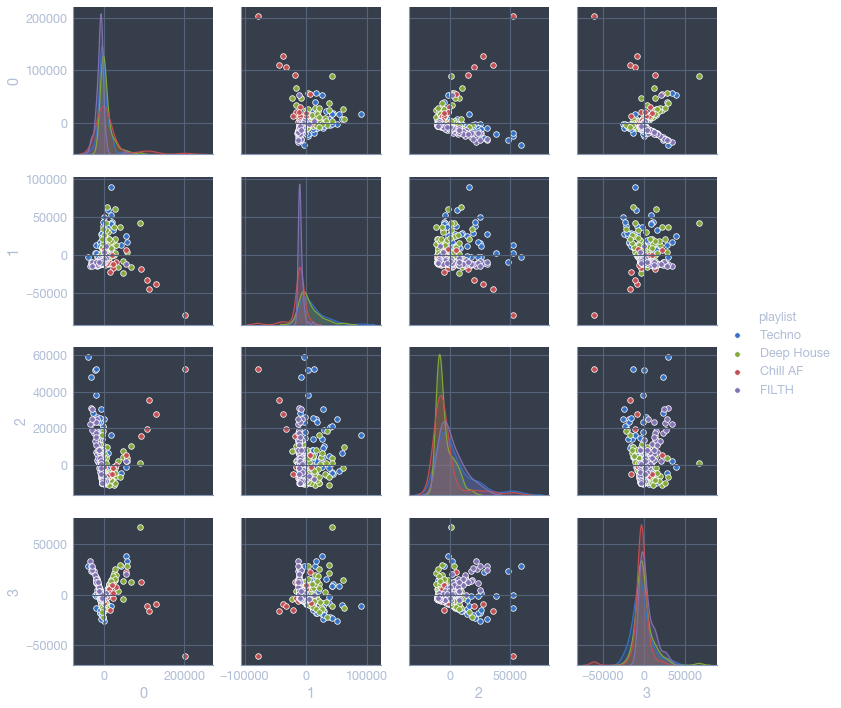

In [63]:
from sklearn.decomposition import *

df = p_timbres.copy()
df = df.iloc[:,-1:].join(pd.DataFrame(KernelPCA(4, kernel='poly', degree=3).fit_transform(df.iloc[:,:-1]), index=df.index))
sns.pairplot(df, hue='playlist')

In [5]:
from sklearn.preprocessing import PowerTransformer, scale, StandardScaler, QuantileTransformer, RobustScaler
from sklearn.decomposition import PCA, FactorAnalysis

playlist_names = ['Techno', 'Deep House', 'Chill AF', 'FILTH']
p_features = []

for name in playlist_names:
    df = get_track_features(playlists[name])
#     df = pd.DataFrame(PowerTransformer().fit_transform(df), columns=df.columns, index=df.index)
    df['playlist'] = name
#     for prev_df in p_features:
#         df = df[~df.index.isin(prev_df)]
#     df = df[df.index.isin(features.index)]
    p_features.append(df)
    
p_features = pd.concat(p_features)
p_features = p_features[~p_features.index.duplicated()]
p_features = p_features.drop(['key', 'mode', 'time_signature', 'liveness'], axis=1)
t_features = p_features.copy()

# p_features.iloc[:,:-1] = RobustScaler().fit_transform(p_features.iloc[:,:-1])
t_features.iloc[:,:-1] = QuantileTransformer(output_distribution='normal').fit_transform(t_features.iloc[:,:-1])

c:\python37\lib\site-packages\sklearn\preprocessing\data.py:2239: UserWarning: n_quantiles (1000) is greater than the total number of samples (354). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


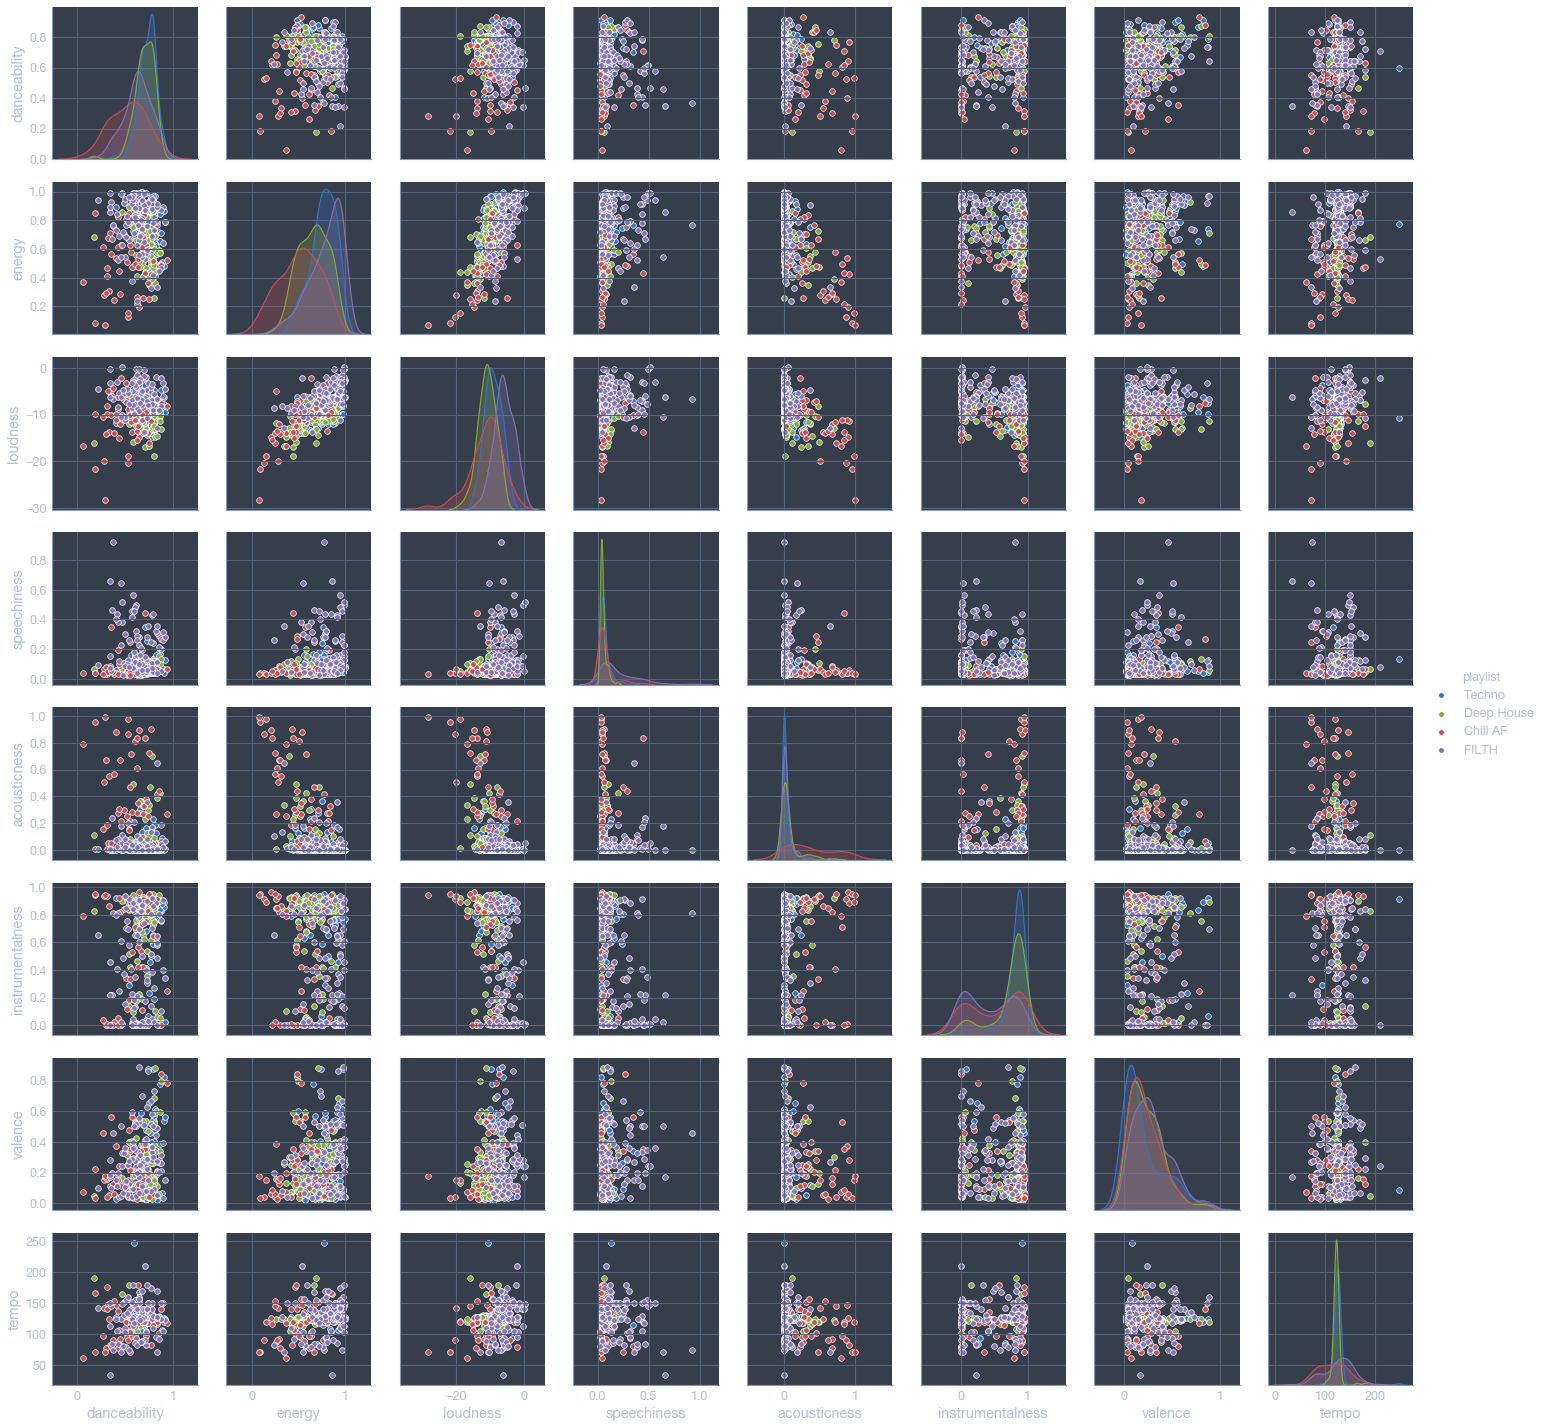

In [10]:
df = p_features
# df = df.iloc[:,-1:].join(pd.DataFrame(PCA(8).fit_transform(df.iloc[:,:-1]), index=df.index))

sns.pairplot(df, hue='playlist')

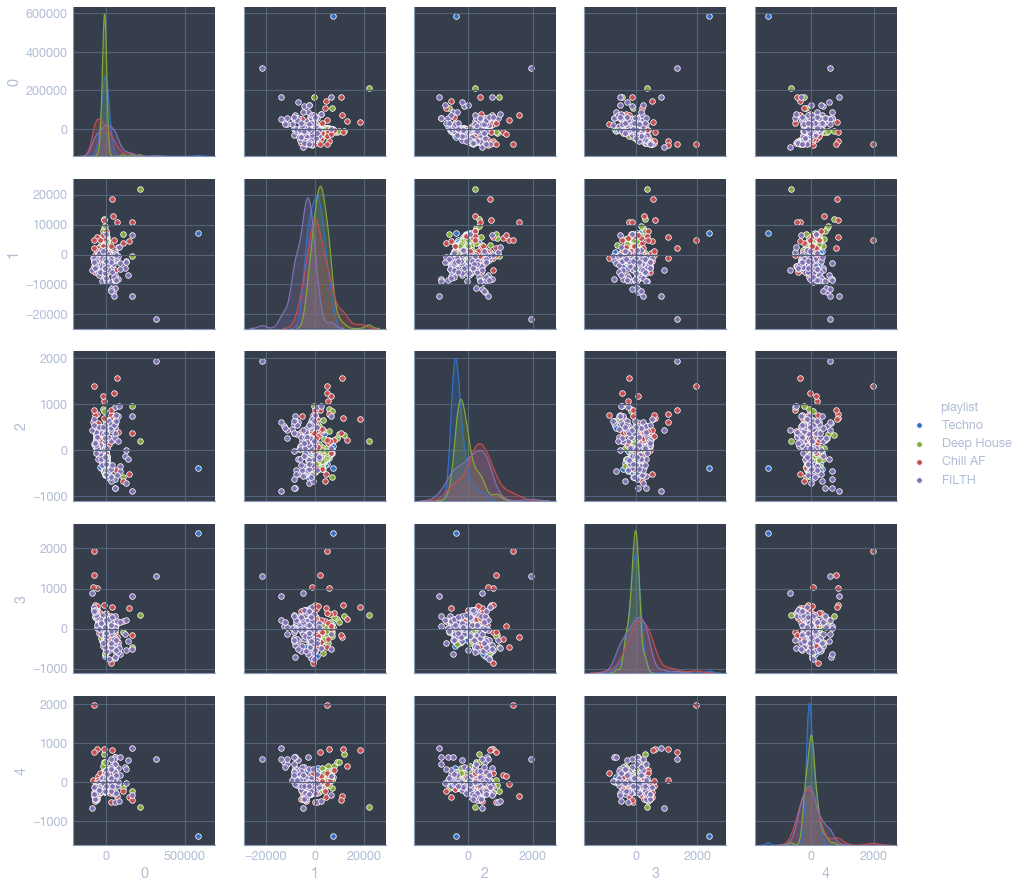

In [12]:
from sklearn.decomposition import *

t_features = p_features.copy()
# t_features.iloc[:,:-1] = QuantileTransformer(output_distribution='normal').fit_transform(t_features.iloc[:,:-1])
# t_features.iloc[:,:-1] = PowerTransformer().fit_transform(t_features.iloc[:,:-1])

df = p_features
df = df.iloc[:,-1:].join(pd.DataFrame(KernelPCA(5, kernel='poly', degree=3).fit_transform(df.iloc[:,:-1]), index=df.index))

sns.pairplot(df, hue='playlist')

No handles with labels found to put in legend.


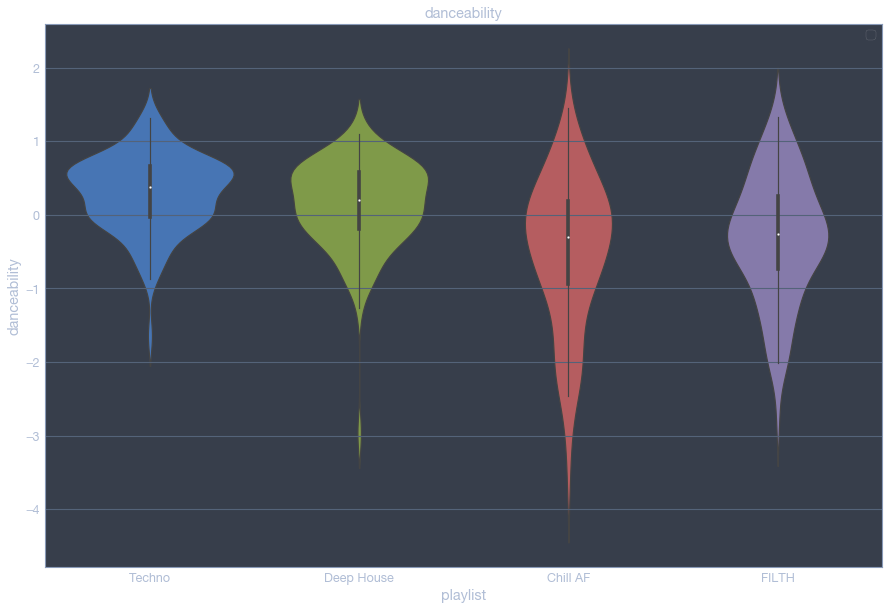

No handles with labels found to put in legend.


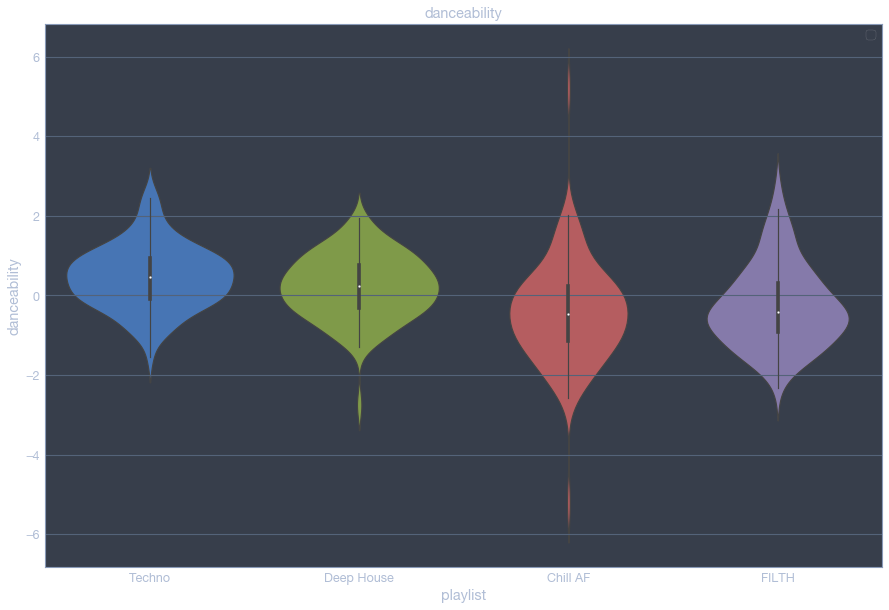

No handles with labels found to put in legend.


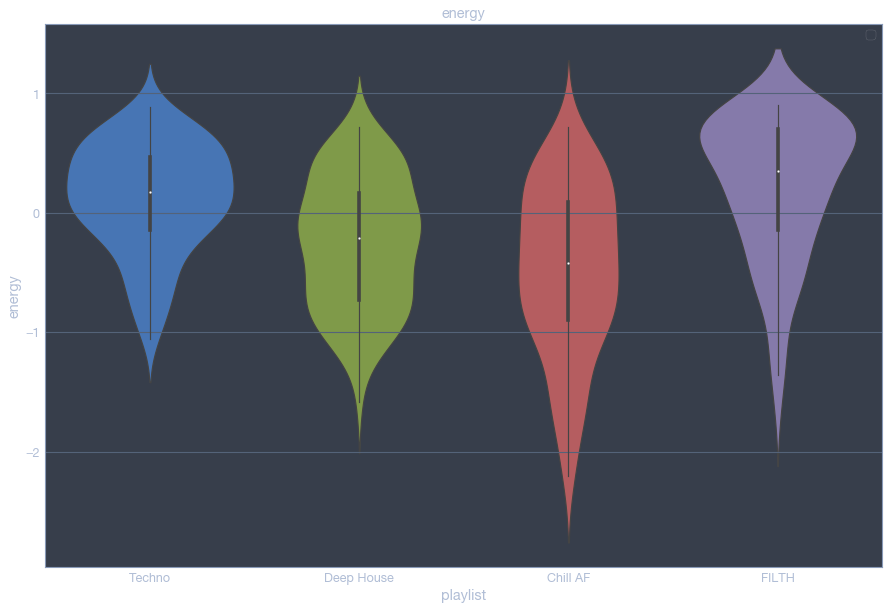

No handles with labels found to put in legend.


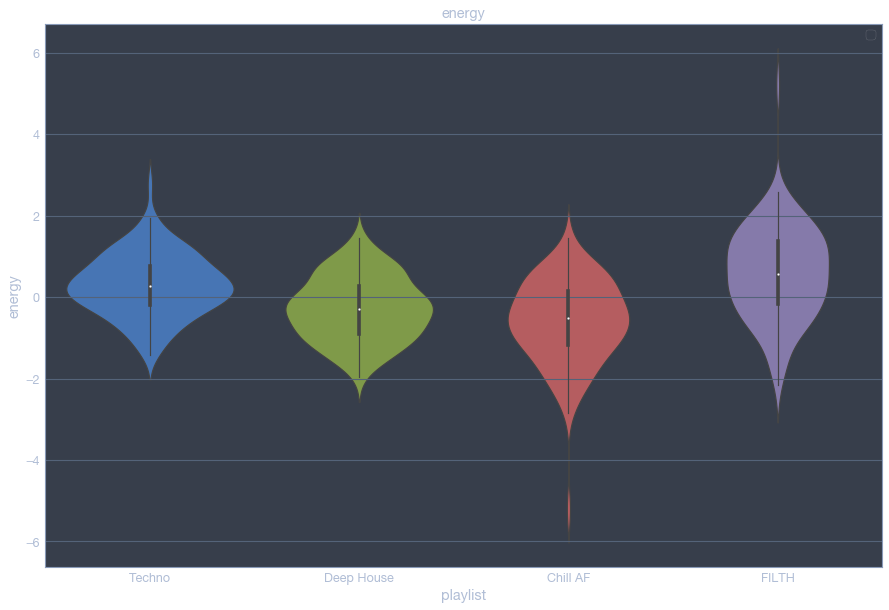

No handles with labels found to put in legend.


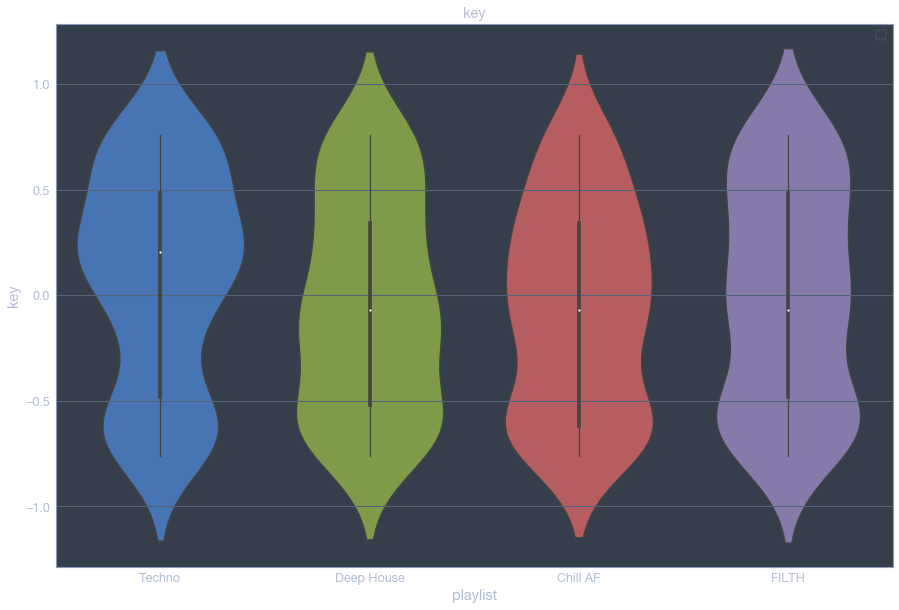

No handles with labels found to put in legend.


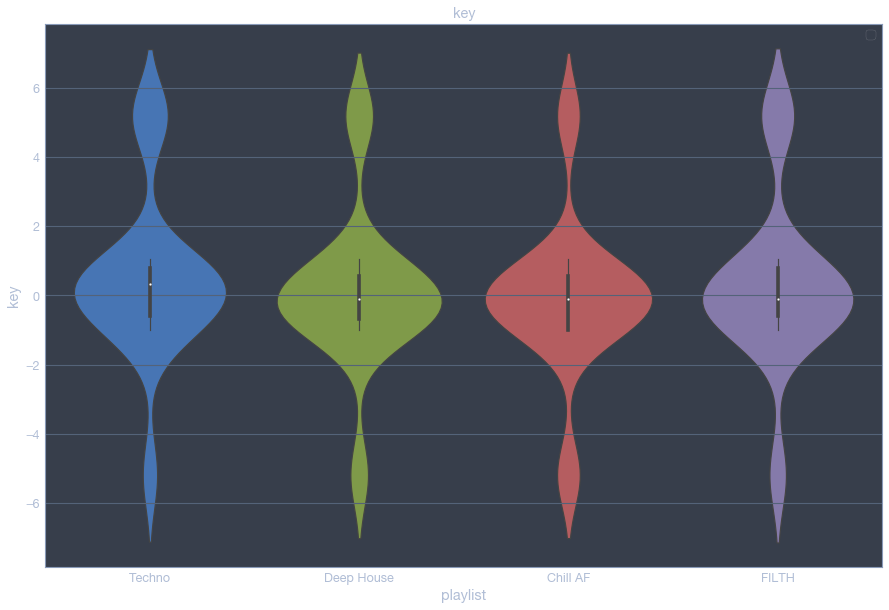

No handles with labels found to put in legend.


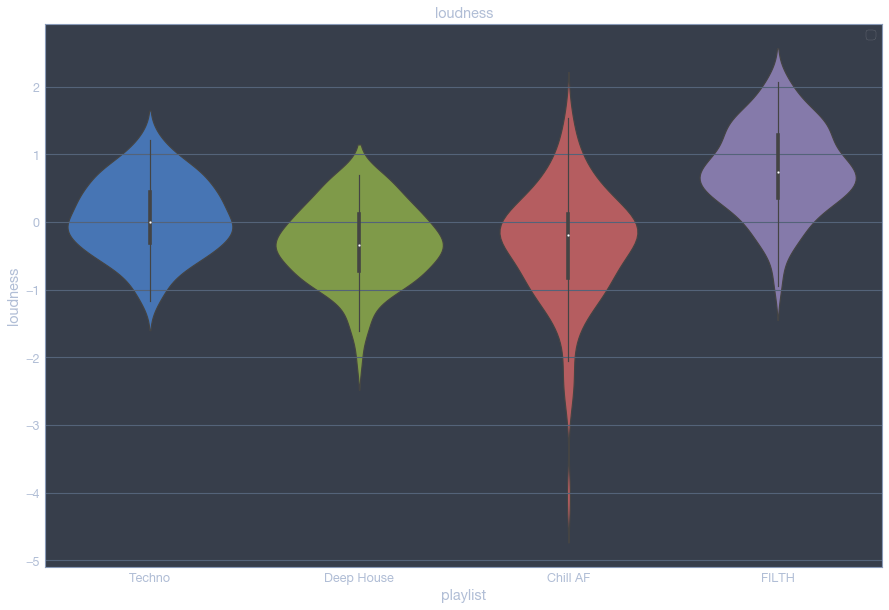

No handles with labels found to put in legend.


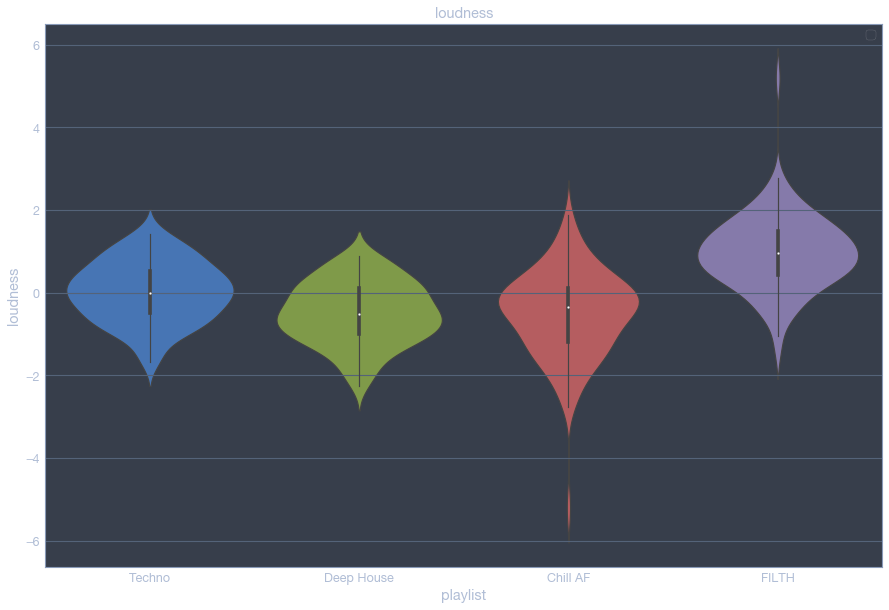

No handles with labels found to put in legend.


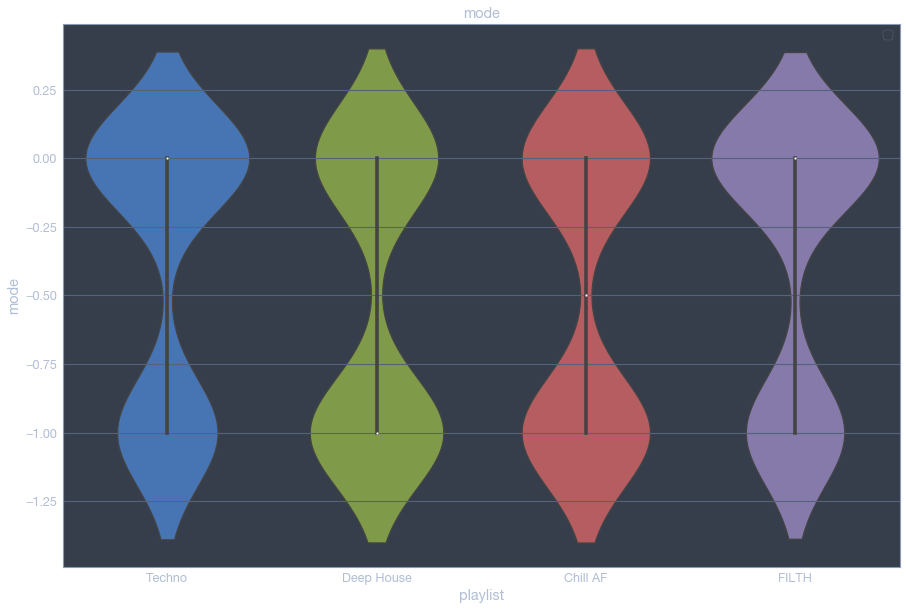

No handles with labels found to put in legend.


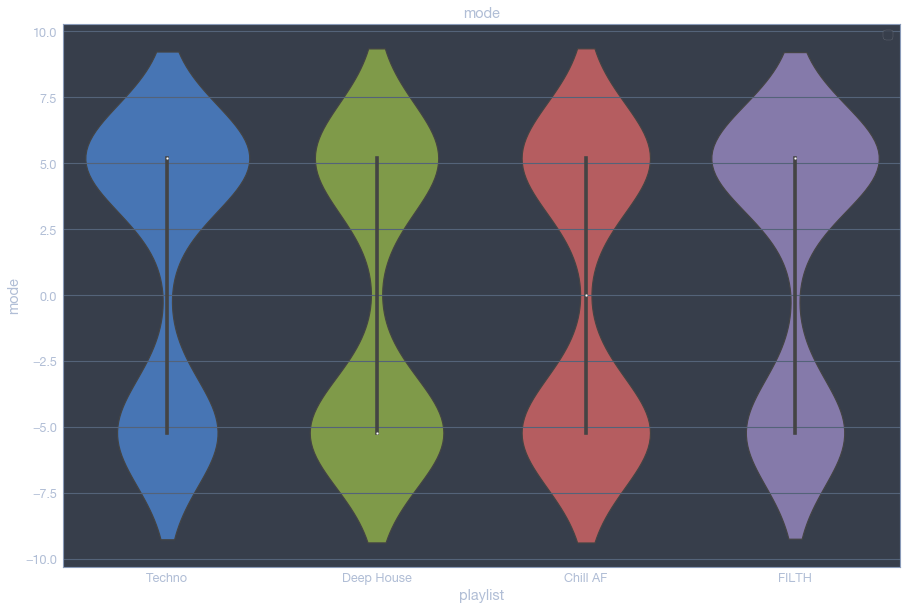

No handles with labels found to put in legend.


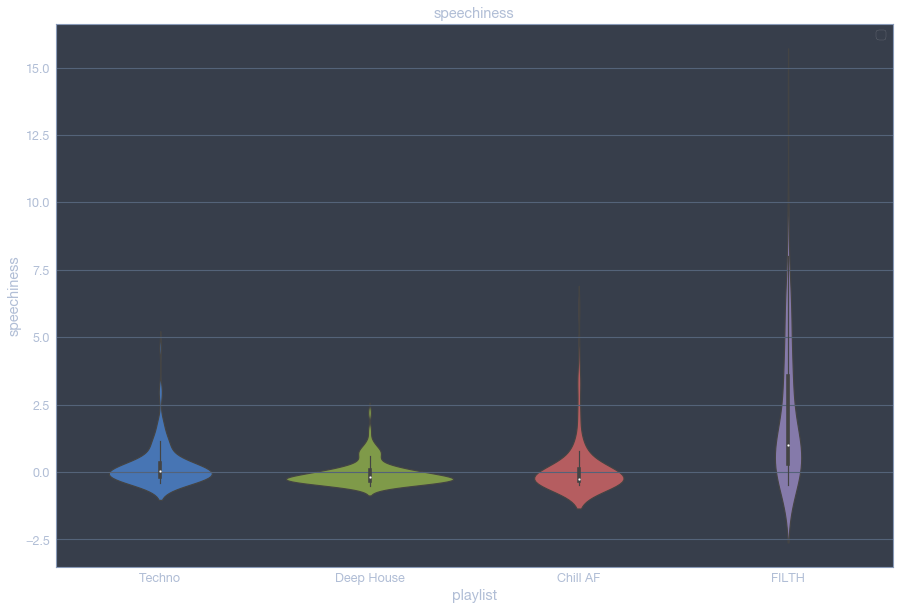

No handles with labels found to put in legend.


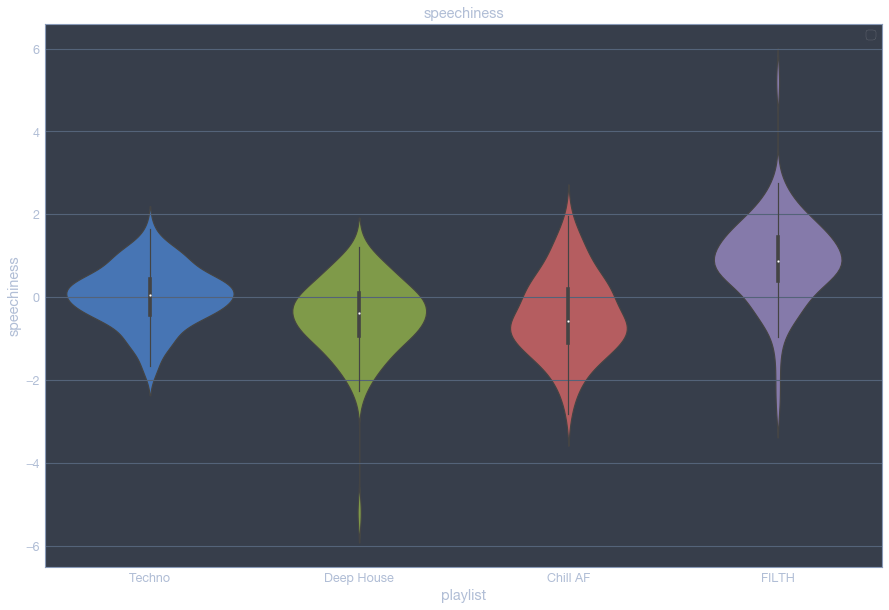

No handles with labels found to put in legend.


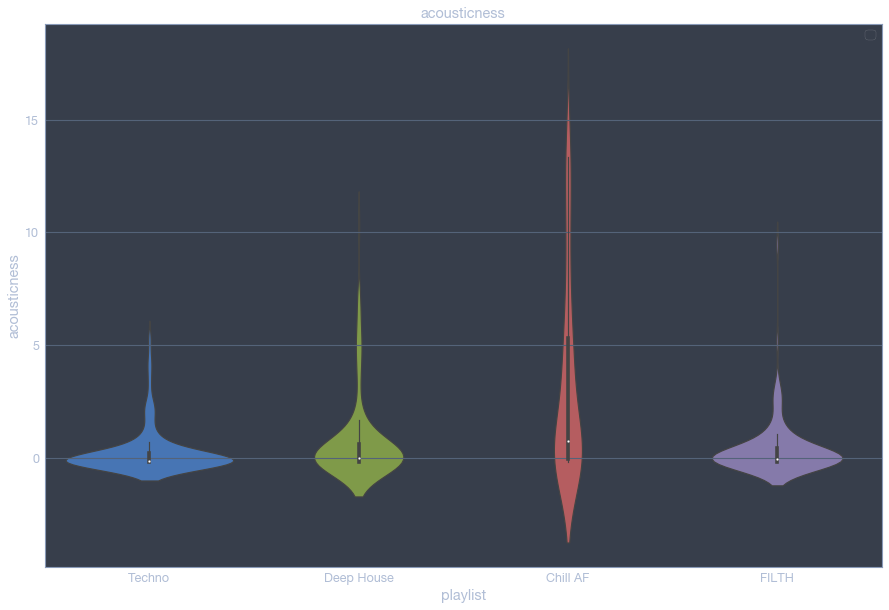

No handles with labels found to put in legend.


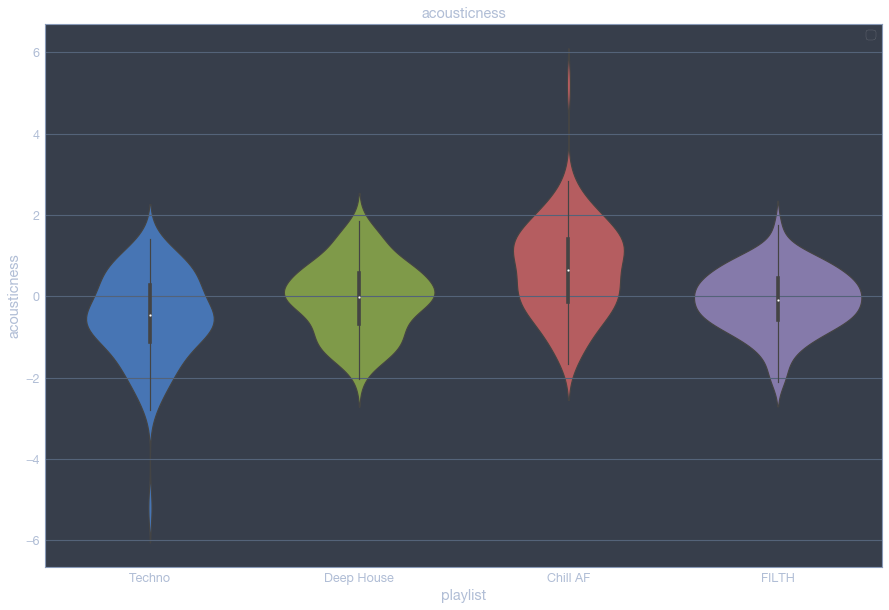

No handles with labels found to put in legend.


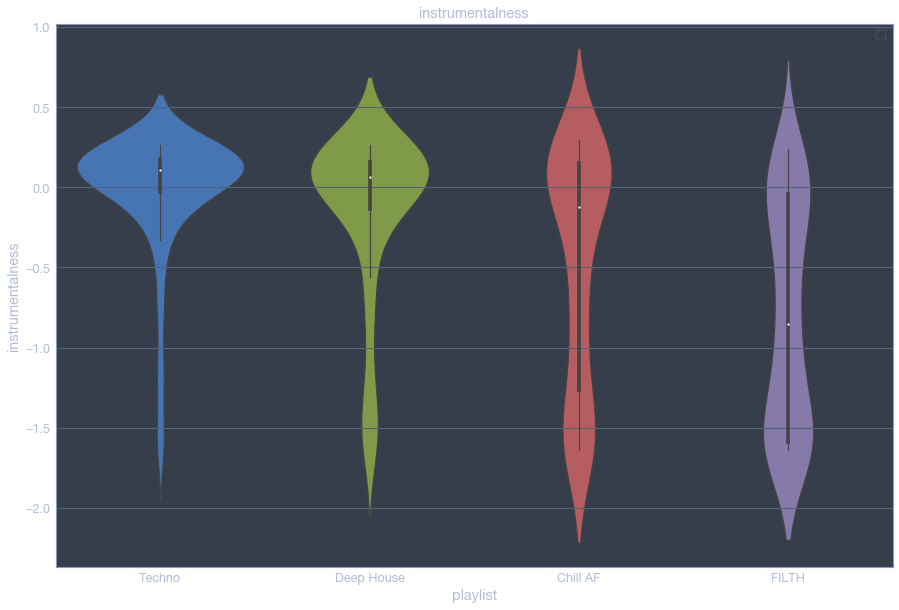

No handles with labels found to put in legend.


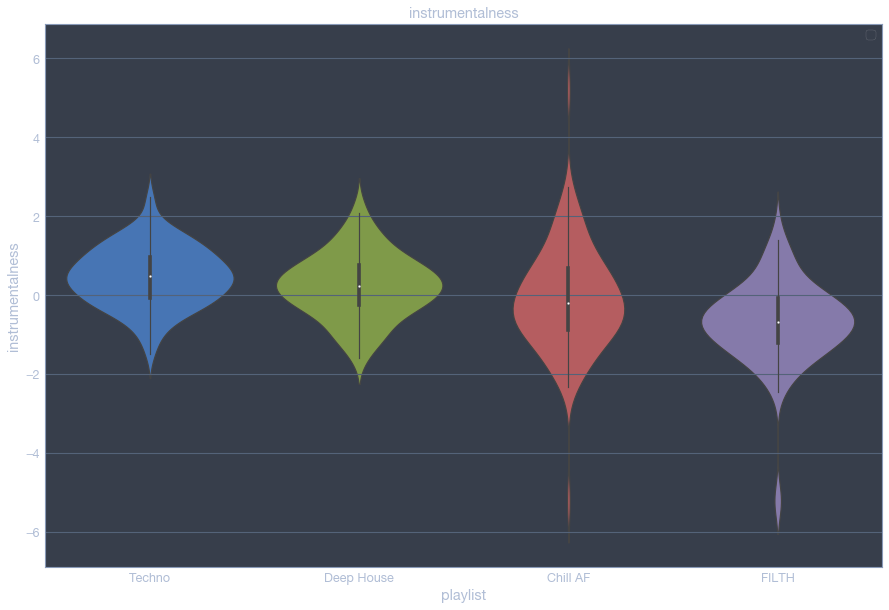

No handles with labels found to put in legend.


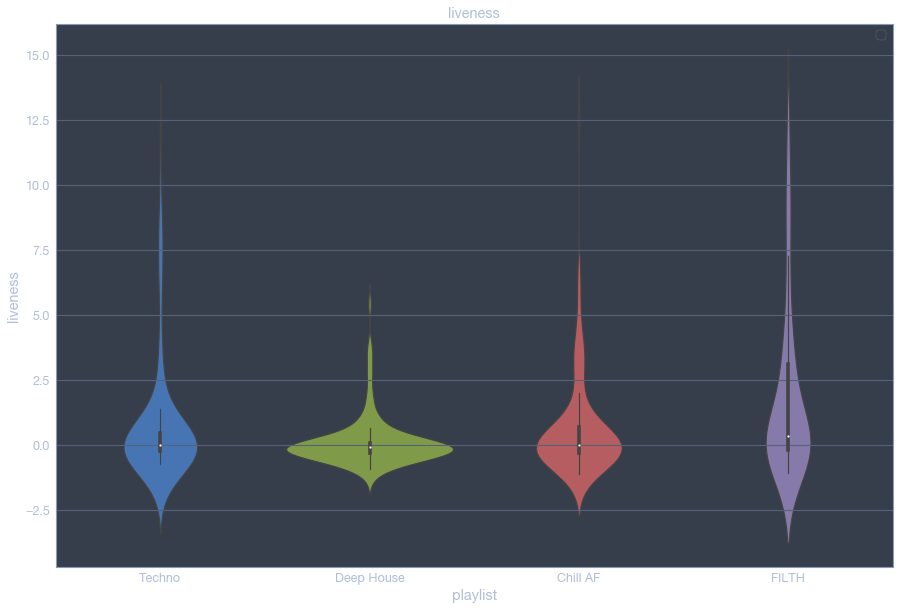

No handles with labels found to put in legend.


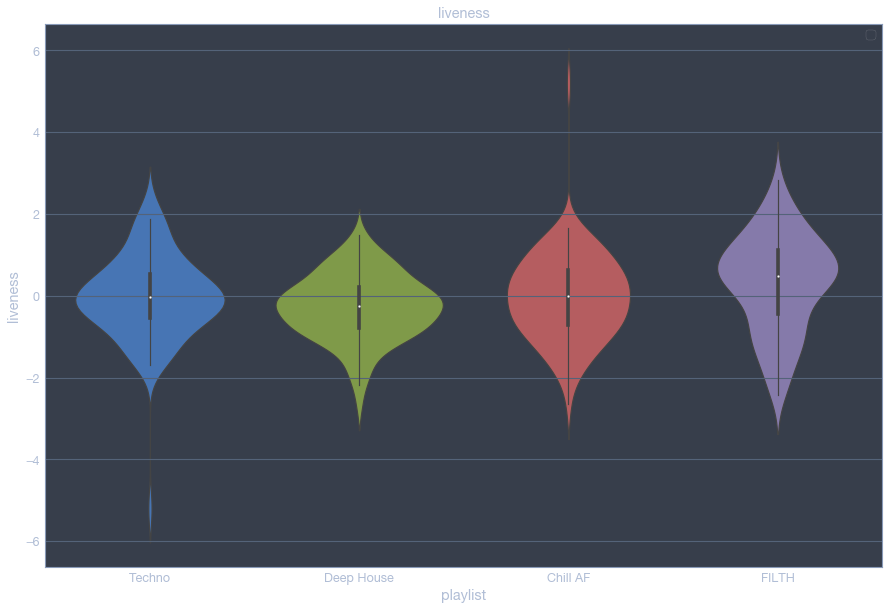

No handles with labels found to put in legend.


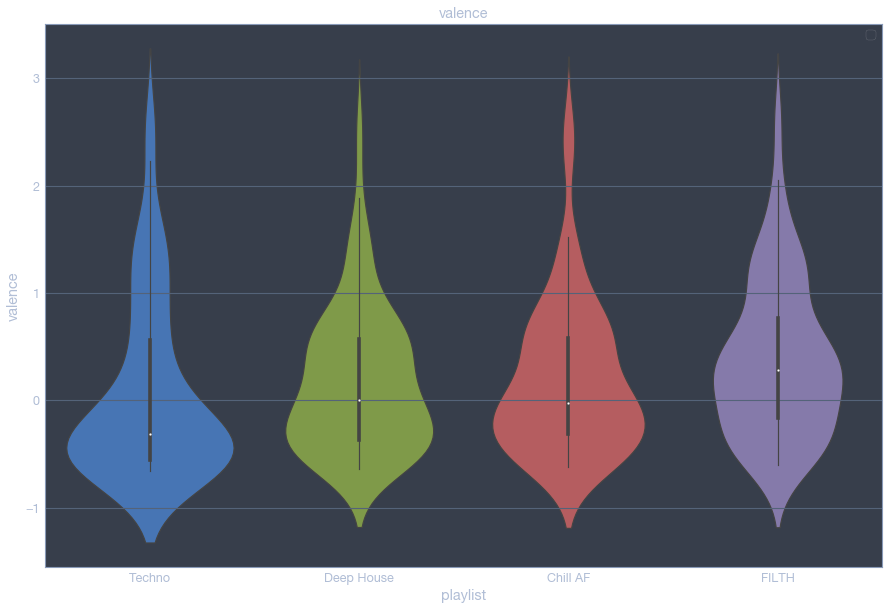

No handles with labels found to put in legend.


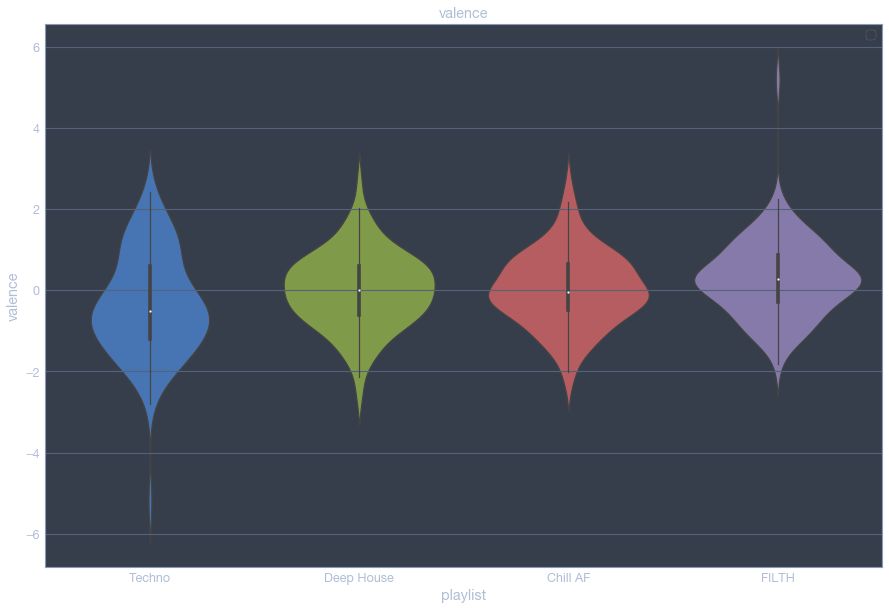

No handles with labels found to put in legend.


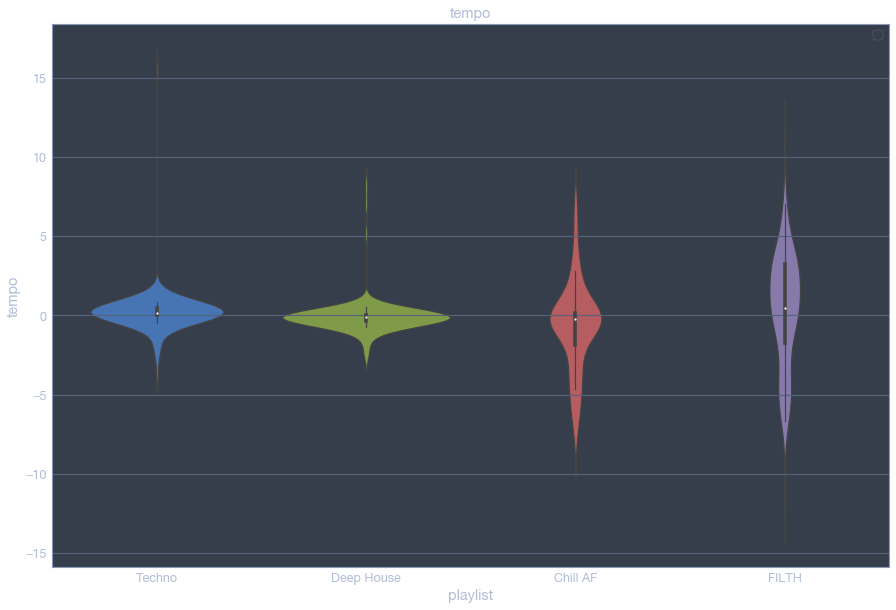

No handles with labels found to put in legend.


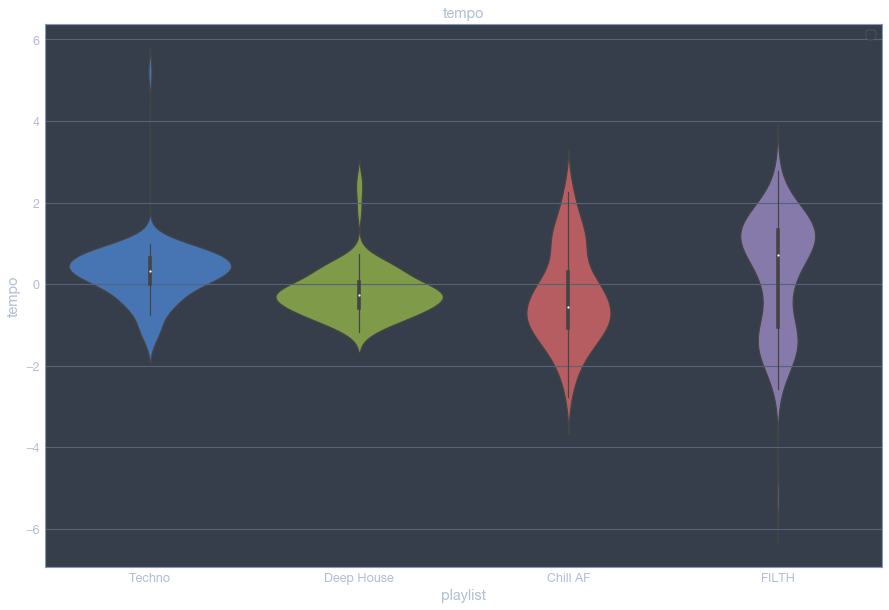

No handles with labels found to put in legend.


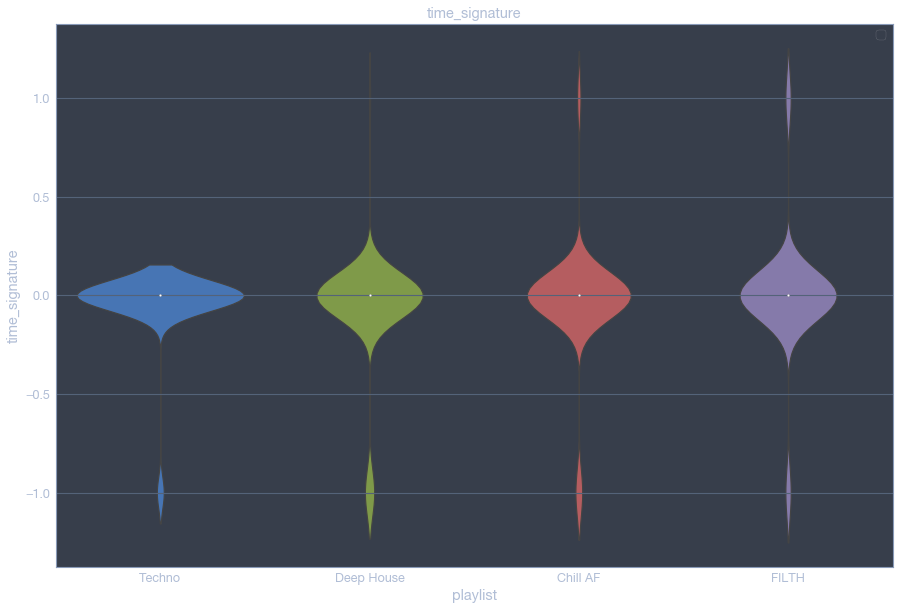

No handles with labels found to put in legend.


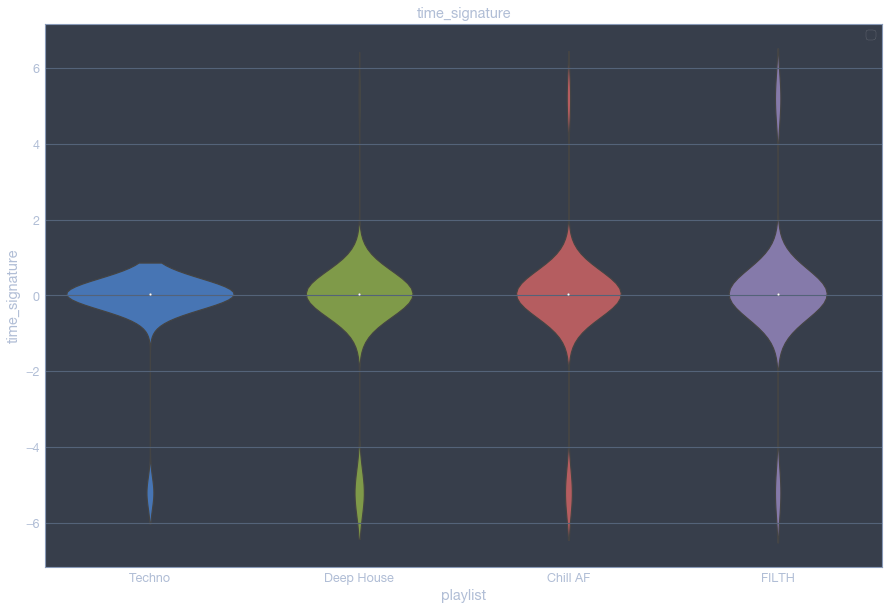

In [21]:
feature_list = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature'
]

for feature in feature_list:
    plt.figure(figsize=(15,10))
    sns.violinplot(x='playlist', y=feature, data=p_features[['playlist', feature]])
    plt.legend()
    plt.title(feature)
    plt.show()
    
    plt.figure(figsize=(15,10))
    sns.violinplot(x='playlist', y=feature, data=t_features[['playlist', feature]])
    plt.legend()
    plt.title(feature)
    plt.show()